In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from github import Github, Label
from pprint import pprint

In [18]:
# Load DataFrame if you don't want to scrape the everything again
df = pd.read_csv("issue_data.csv")

In [28]:
# ==========================================
# DONT FORGET TO INSERT CREDENTIALS
# ==========================================
g = Github("", "")
repo = g.get_repo("CleverRaven/Cataclysm-DDA")
#open_issues = repo.get_issues(state='open')
#closed_issues = repo.get_issues(state='closed')
issues = repo.get_issues(state='all')

In [29]:
data = []
comment_data = []

In [30]:
def check_labels(issue, label_string):
    for label in issue.labels:
        if label.name == label_string:
            bug_label = label
            return True
    return False

In [31]:
# use a counter to track progress
counter = 0

# Pull Requests also count as Issues, so expected duration should be 
# around 15000
for issue in issues:
    # take issues only with [BUG] label
    if check_labels(issue, "Bug"):
        for label in issue.labels:
            data.append([issue.id, label.name, issue.comments])
            
    # Take all issues, labels and comments
    for label in issue.labels:
        comment_data.append([issue.id, label.name, issue.comments])
        
    counter += 1
    if counter % 50 == 0:
        print("Done pass %d" % counter)

Done pass 50
Done pass 100
Done pass 150
Done pass 200
Done pass 250
Done pass 300
Done pass 350
Done pass 400
Done pass 450
Done pass 500
Done pass 550
Done pass 600
Done pass 650
Done pass 700
Done pass 750
Done pass 800
Done pass 850
Done pass 900
Done pass 950
Done pass 1000
Done pass 1050
Done pass 1100
Done pass 1150
Done pass 1200
Done pass 1250
Done pass 1300
Done pass 1350
Done pass 1400
Done pass 1450
Done pass 1500
Done pass 1550
Done pass 1600
Done pass 1650
Done pass 1700
Done pass 1750
Done pass 1800
Done pass 1850
Done pass 1900
Done pass 1950
Done pass 2000
Done pass 2050
Done pass 2100
Done pass 2150
Done pass 2200
Done pass 2250
Done pass 2300
Done pass 2350
Done pass 2400
Done pass 2450
Done pass 2500
Done pass 2550
Done pass 2600
Done pass 2650
Done pass 2700
Done pass 2750
Done pass 2800
Done pass 2850
Done pass 2900
Done pass 2950
Done pass 3000
Done pass 3050
Done pass 3100
Done pass 3150
Done pass 3200
Done pass 3250
Done pass 3300
Done pass 3350
Done pass 3400


In [57]:
df = pd.DataFrame(data)
df.columns=["id", "label", "comments"]
df.head(5)

,id,label,comments
0,286514389,Bug,0
1,286514389,NPC,0
2,286514389,Vehicle,0
3,286514389,Z-levels,0
4,285666680,Bug,0


In [58]:
df.groupby(['label']).count()
df.groupby(['label']).sum()

agg = pd.DataFrame(df.groupby(['label']).count())
agg.comments = df.groupby(['label']).sum()['comments']
agg.colums = ["label", "issues", "comments"]
agg = agg.drop(['Bug', 'Confirmed', 'Confirmation Needed', 
                'Easy-fix', 'Duplicate', 'Performance',
                'Question', 'Windows', 'OSX',
                'Mechanics Change', 'Suggestion (Discuss)',
                'Enhancement', 'Translation', 'Long-term', 'Code',
                'Crash / Freeze', 'Other', 'Balance',
                'Priority', 'Mods'])


In [ ]:
# Only if loading from CSV
agg = agg.drop(["Unnamed: 0"], axis=1)

In [60]:
agg.sort_values('id', ascending=False).head(10)

,id,comments
label,,
Information / Interface,364,1215
NPC,141,374
Vehicle,98,441
Mapgen,52,271
Crafting / Construction,47,184
Mission,35,124
JSON,33,98
Gunmod / Toolmod,18,57
Magazine,17,66


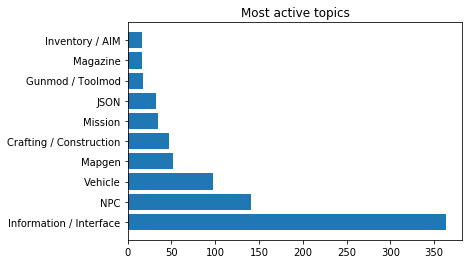

In [96]:
# Plot most active categories
to_plot = agg.sort_values('id', ascending=False).head(10)

plt.barh([i for i in range(len(to_plot.index))],
        to_plot['id'])

plt.yticks([i for i in range(len(to_plot.index))], 
           to_plot.index)
plt.title("Most active topics")
plt.show()

In [62]:
# normalize, not sure if we need it...
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(agg)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.index = agg.index
df_normalized.columns = agg.columns
df_normalized.sort_values('id', ascending=False).head(5)

,id,comments
label,,
Information / Interface,1.000000,1.000000
NPC,0.385675,0.306678
Vehicle,0.267218,0.361913
Mapgen,0.140496,0.221764
Crafting / Construction,0.126722,0.150041


In [63]:
# Save to csv
df.to_csv("issue_data.csv")

In [64]:
# Linear Regression to compare ID to COMMENT and calculate the error.
# negative error, means that the module is badly understood
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(agg["id"].values.reshape(-1,1), 
         agg['comments'].values.reshape(-1,1))

pred = regr.predict(agg["id"].values.reshape(-1,1))
error = agg['comments'].values.reshape(-1,1) - pred

In [102]:
df_new = agg.copy()
df_new["understanding"] = error
df_new.sort_values("understanding", ascending=False).head(5)

,id,comments,understanding
label,,,
Vehicle,98,441,106.135555
Mapgen,52,271,88.237204
Tiles,9,65,24.419180
Crafting / Construction,47,184,17.769992
Battery,11,56,8.806065


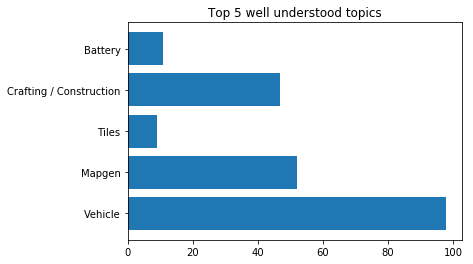

In [103]:

# Plot most well understood topics
to_plot = df_new.sort_values("understanding", ascending=False).head(5)

plt.barh([i for i in range(len(to_plot.index))],
        to_plot['id'])

plt.yticks([i for i in range(len(to_plot.index))], 
           to_plot.index)
plt.title("Top 5 well understood topics")
plt.show()

In [104]:
df_new.sort_values("understanding").head(5)

,id,comments,understanding
label,,,
NPC,141,374,-103.046421
Inventory / AIM,16,36,-27.726723
JSON,33,98,-21.938202
Mutations,6,14,-16.661148
Tests,2,2,-15.434917


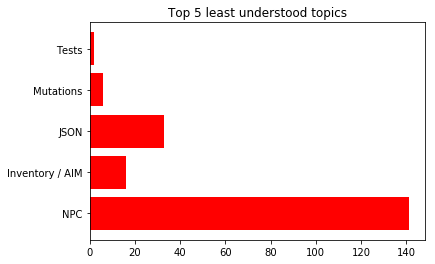

In [105]:
# Plot least well understood topics
to_plot = df_new.sort_values("understanding").head(5)

plt.barh([i for i in range(len(to_plot.index))],
        to_plot['id'], color='r')

plt.yticks([i for i in range(len(to_plot.index))], 
           to_plot.index)
plt.title("Top 5 least understood topics")
plt.show()

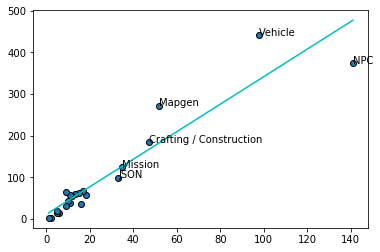

In [93]:
to_plot = agg.drop(['Information / Interface']).sort_values("id", ascending=False)
plt.scatter(to_plot.id, 
            to_plot.comments,
            edgecolor='k')

plt.plot(to_plot.id, 
         regr.predict(to_plot.id.values.reshape(-1,1)), 
         '-', c='c')

for i in range(6):
    plt.annotate(to_plot.index[i], (to_plot.id[i], to_plot.comments[i]))

plt.show()